In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax

In [85]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

def toc(tte: np.ndarray):
    corridor = 5
    return len(tte[tte > corridor]) / 2

def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [86]:
env_selector = OctorotorEnvSelector()
pid_sl_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':10}
pid_sl_agent = PIDAgent()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000}
pid_agent = PIDAgent()

study, naive_agent, naive_params = get_agent('naive')
naive_params['steps_u'] = 50
naive_params['bounding_rect_length']=1000

study, oracle_agent, oracle_params = get_agent('oracle')
oracle_params['steps_u'] = 50
oracle_params['bounding_rect_length']=1000

study, lstm_agent, lstm_params = get_agent('windlstm')
lstm_params['steps_u'] = 50
lstm_params['bounding_rect_length']=1000

[I 2023-09-29 13:32:13,143] Using an existing study with name 'naive' instead of creating a new one.
[I 2023-09-29 13:32:13,216] Using an existing study with name 'oracle' instead of creating a new one.
[I 2023-09-29 13:32:13,262] Using an existing study with name 'windlstm' instead of creating a new one.


In [87]:
all_agents = [pid_agent, lstm_agent]
all_params = [pid_params, lstm_params]
types = ["sliding", "lstm"]
names = ['PID', 'DI-RL']

In [88]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [89]:
traj_len = 500 # trajectory seems to be around 500 seconds to complete
direction_changes = [1,2,3]
num_repeat = 25

In [90]:
def sample_wind():
    wind_vec = np.random.uniform(-10,10,2)
    mag = np.linalg.norm(wind_vec)
    
    if mag > 10:
        wind_vec = wind_vec * (10/mag)

    return wind_vec

In [91]:
# Evaluates all saved agents with their params on a wind range
def wind_injection(agents, params, types, names, traj_len, direction_changes, num_repeat):
    results = pd.DataFrame(columns=['Agent', 'Changes', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])
    for num_changes in tqdm(direction_changes):
        for agent, param, env_type, name in tqdm(zip(agents, params, types, names), total=len(agents)):
            for i in range(num_repeat):

                changes_triggered = 0
                split_time = traj_len // num_changes
                random_time = int(np.random.uniform(0,split_time))
                change_time = changes_triggered * split_time + random_time
                
                env = env_selector.get_env(env_type, param, [(0,0),(0,0),(0,0)], nasa_wp, has_turbulence=True, start_alt=30)
                done = False
                state = env.reset()
                state = np.array(state, dtype=np.float32)
                log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                                  other_vars=('reward',))
                index = 0
                while not done:
                    if index == change_time:
                        changes_triggered += 1
                        change_time = changes_triggered * split_time + random_time
                        wind_vec = sample_wind()
                        env.base_env.wind_x = wind_vec[0]
                        env.base_env.wind_y = wind_vec[1]
                        env.base_env.get_turbulence(env.base_env.prev_waypt, env.base_env.next_waypt)
                        
                    action = agent.predict(state, deterministic=True)[0] 
                    state, reward, done, info = env.step(action)
                    state = np.array(state, dtype=np.float32)
                    log.log(reward=reward)
                    index += 1
                
                log.done_logging()
                traj_err = get_tte(np.array([0,0,0]), log.target.position, log.x, log.y, log.z)
                new_result = {
                    'Agent': name,
                    'Changes': num_changes,
                    'Mean TTE': np.mean(traj_err),
                    'Total TTE': np.sum(traj_err),
                    'Completed Mission': completed_mission(nasa_wp, log.x, log.y, log.z, radius=5),
                    'Reward': np.sum(log.reward),
                    'Time Outside Corridor': toc(traj_err)
                }
                results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [92]:
sample_wind()

array([0.97627008, 4.30378733])

In [93]:
results = wind_injection(all_agents, all_params, types, names, traj_len, direction_changes, num_repeat)

 50%|█████████████████████████████████████                                     | 1/2 [04:19<04:19, 259.29s/it]/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [40:40<00:00, 813.52s/it]


In [94]:
results.to_csv('./data/wind_changing_turbulence.csv')

In [2]:
results = pd.read_csv('./data/wind_changing_turbulence.csv')

In [96]:
results

,Unnamed: 0,Agent,Changes,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,PID,1,1786.430172,8.347805,True,7041.9775,64.0
1,1,PID,1,1904.198867,8.898126,True,5851.1094,71.0
2,2,PID,1,2867.978500,8.265068,False,-20881.7700,168.5
3,3,PID,1,1764.065782,8.092045,True,7315.0356,61.5
4,4,PID,1,1797.173252,8.398006,True,6965.9670,67.0
...,...,...,...,...,...,...,...,...
145,145,DI-RL,3,568.610844,1.002841,True,14339.3970,0.5
146,146,DI-RL,3,586.817007,1.025904,True,14171.3640,0.5
147,147,DI-RL,3,564.170016,0.964393,True,14362.6110,0.5
148,148,DI-RL,3,472.586728,0.836437,True,15272.4200,0.5


In [97]:
results[results['Agent']=='PID'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].mean()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,
1,1987.514059,8.558903,74.56,3368.005498,0.88
2,2910.381259,9.709125,105.00,-4193.503481,1.00
3,2662.647831,10.792498,73.96,-1623.967376,1.00


In [98]:
results[results['Agent']=='PID']

,Unnamed: 0,Agent,Changes,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,PID,1,1786.430172,8.347805,True,7041.9775,64.0
1,1,PID,1,1904.198867,8.898126,True,5851.1094,71.0
2,2,PID,1,2867.978500,8.265068,False,-20881.7700,168.5
3,3,PID,1,1764.065782,8.092045,True,7315.0356,61.5
4,4,PID,1,1797.173252,8.398006,True,6965.9670,67.0
...,...,...,...,...,...,...,...,...
120,120,PID,3,2469.368093,11.379576,True,371.4956,78.0
121,121,PID,3,2971.089324,13.323271,True,-4681.7812,80.0
122,122,PID,3,1655.657950,7.629760,True,8361.3910,59.5
123,123,PID,3,3878.449556,17.709815,True,-13687.4250,80.0


In [99]:
results[results['Agent']=='PID'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].std()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,
1,427.710499,1.797892,30.075710,7259.163420,0.331662
2,1299.288296,3.383263,57.255822,13045.351446,0.000000
3,1065.149220,3.834427,17.771653,10624.528115,0.000000


In [100]:
results[results['Agent']=='DI-RL'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].mean()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,
1,536.802211,0.948197,1.92,14640.835480,1.0
2,679.734488,1.188528,2.32,13234.846828,1.0
3,611.653301,1.069725,2.56,13908.272960,1.0


In [101]:
results[results['Agent']=='DI-RL'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].std()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,
1,147.141540,0.260796,3.936157,1455.272145,0.0
2,181.508794,0.317124,4.970496,1796.827039,0.0
3,192.341345,0.325204,6.635322,1904.752762,0.0


## Plots

In [7]:
filtered_results['Agent'] = filtered_results['Agent'].replace('DI-RL', 'RL-DR')

Text(0.5, 0, 'Number of Wind Field Changes')

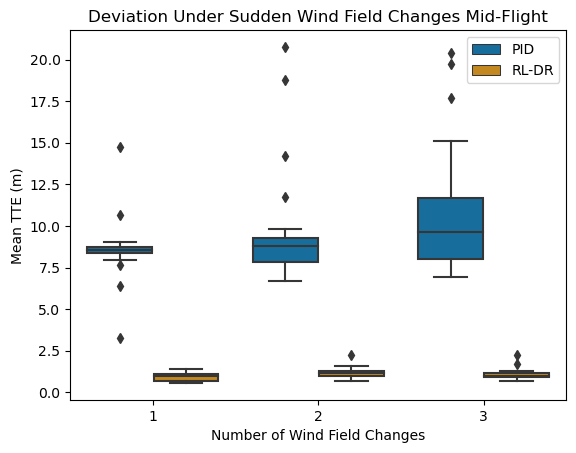

In [8]:
import seaborn as sns

plt.title("Deviation Under Sudden Wind Field Changes Mid-Flight")
# filtered_results = results[results['Agent'] == 'DI-RL']
filtered_results = results
sns.boxplot(x=filtered_results['Changes'], y=filtered_results['Mean TTE'], hue=filtered_results['Agent'], palette='colorblind')
plt.legend()
plt.ylabel("Mean TTE (m)")
plt.xlabel("Number of Wind Field Changes")